In [47]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

from fbprophet import Prophet
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os 
import pandas as pd
from google.colab import files
import warnings
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import concatenate
from math import sqrt
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.utils import np_utils

## 데이터셋

In [48]:
#데이터 읽자
#천단위 콤마 제거 해주자 나중에 또 하기 귀찮으니까!(결정적으로 float형 유지를 위해)
df = pd.read_csv('exchange_rate_fix_20210223.xls.csv', thousands = ',')
print(df.shape)
df.tail()

(1762, 8)


,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,달러지수 (종가),콜금리,KOSPI
1757,2021.02.17,"1,099.70",6764.11,0.87,NaN,90.95,0.47,"3,133.73"
1758,2021.02.18,"1,107.70",6652.76,0.87,NaN,90.59,0.49,"3,086.66"
1759,2021.02.19,"1,105.70",6712.32,0.86,NaN,90.36,0.51,"3,107.62"
1760,2021.02.22,"1,107.10",6635.92,0.86,NaN,90.01,0.50,"3,079.75"
1761,2021.02.23,"1,106.50",6607.24,0.86,NaN,90.17,0.49,"3,070.09"


In [49]:
#열이름 한국어인거 영어로 변경하자
name = ["Date", "ExchangeRate","KRX100", "KORIBOR", "LIBOR", "DollarRate",
       "CallRate","KOSPI"]
df1= df.rename(columns = dict(zip(df.columns,name)))

In [50]:
#천단위 쉼표 제거
df1['ExchangeRate'] = df1['ExchangeRate'].str.replace(',','')
df1['KOSPI'] = df1['KOSPI'].str.replace(',','')
df1.tail()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.70,6764.11,0.87,NaN,90.95,0.47,3133.73
1758,2021.02.18,1107.70,6652.76,0.87,NaN,90.59,0.49,3086.66
1759,2021.02.19,1105.70,6712.32,0.86,NaN,90.36,0.51,3107.62
1760,2021.02.22,1107.10,6635.92,0.86,NaN,90.01,0.50,3079.75
1761,2021.02.23,1106.50,6607.24,0.86,NaN,90.17,0.49,3070.09


In [51]:
#오브젝트형 데이터 실수로 형변환
df1["KOSPI"] = pd.to_numeric(df1.KOSPI, errors='coerce')
df1["ExchangeRate"] = pd.to_numeric(df1.ExchangeRate, errors='coerce')

### 전처리
- 결측값 보간
- 날짜 데이터 형식으로 변경
- 시각화
- 데이터 셋 분리

In [52]:
#결측값 확인
df1.isna().sum()

Date             0
ExchangeRate     1
KRX100           6
KORIBOR          0
LIBOR           92
DollarRate       7
CallRate         0
KOSPI            7
dtype: int64

In [53]:
#결측치를 값에 선형 비례하는식으로 결측값을 보간해봤다
df_intp = df1.interpolate(method = 'values')

In [54]:
#날짜 데이터타임형식으로 미리 변경해놓자
df_intp['Date'] = pd.to_datetime(df_intp['Date'], errors='coerce')

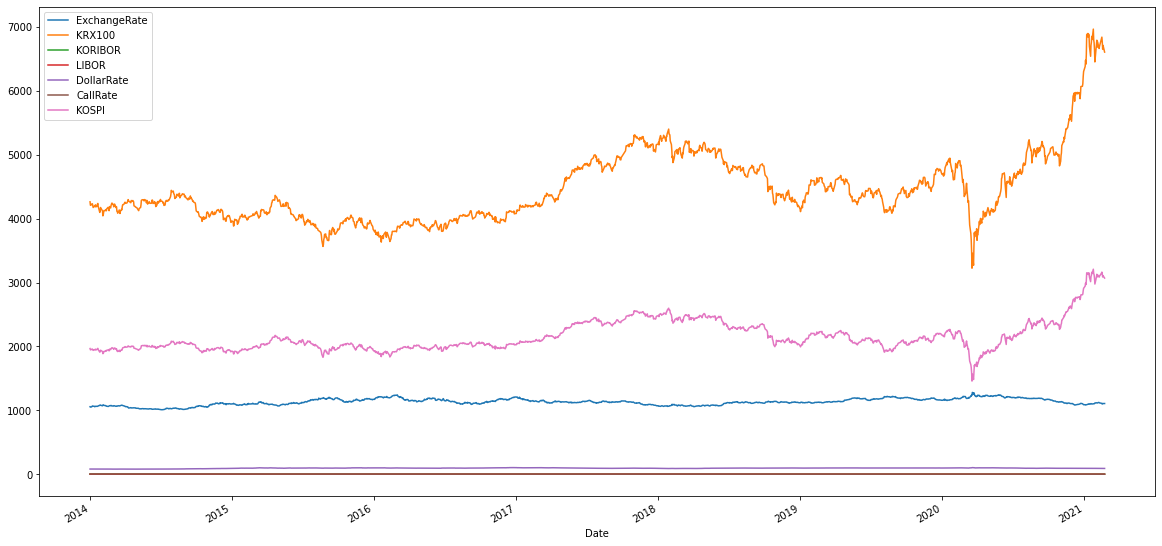

In [55]:
#시각화 해보자
df_intp.plot(x="Date",figsize = (20,10))
#표준화 필수의 느낌이 난다..

In [57]:
#날짜가 인덱스인 경우도 생성 해놓자
#lstm 용
df_date = df_intp.set_index('Date')
df_date.head()

,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2014-01-02,1055.3,4263.64,2.78,0.0956,80.79,2.51,1967.19
2014-01-03,1050.4,4209.03,2.78,0.0950,80.96,2.50,1946.14
2014-01-06,1054.1,4221.13,2.77,0.0945,80.81,2.48,1953.28
2014-01-07,1062.2,4233.05,2.75,0.0926,80.98,2.50,1959.44
2014-01-08,1067.9,4232.26,2.75,0.0925,81.16,2.49,1958.96


In [58]:
#프로핏 용
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS =3
X = df_intp.index
y = df_intp['ExchangeRate']

folds = TimeSeriesSplit(n_splits = N_SPLITS)


In [59]:
feature_columns = [
    'KRX100',
    'KORIBOR',
    'LIBOR',
    'DollarRate',
    'CallRate',
    'KOSPI'
]

target_column = ['ExchangeRate']

train_size = int(0.8* len(df_intp))

multivariate_df = df_intp[['Date']+target_column +feature_columns].copy()
multivariate_df.columns = ['ds', 'y']+ feature_columns
multivariate_df.head()
train_pro = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5,6,7]]),pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5,6,7]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train_pro.head()

,ds,y,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014-01-02,1055.3,4263.64,2.78,0.0956,80.79,2.51,1967.19
1,2014-01-03,1050.4,4209.03,2.78,0.0950,80.96,2.50,1946.14
2,2014-01-06,1054.1,4221.13,2.77,0.0945,80.81,2.48,1953.28
3,2014-01-07,1062.2,4233.05,2.75,0.0926,80.98,2.50,1959.44
4,2014-01-08,1067.9,4232.26,2.75,0.0925,81.16,2.49,1958.96


In [60]:

#lstm용
from sklearn.preprocessing import MinMaxScaler

#scaler 객체 생성
scaler = MinMaxScaler()

#데이터셋 변환
scaler.fit(df_date)
date_scaler = scaler.transform(df_date)

#transform 변환을 하면 배열 형식으로 바뀌는데 그걸 다시 데이터 프레임 형식으로 넘기자
df_scaler = pd.DataFrame(date_scaler, columns = df_date.columns, index = df_date.index)
df_scaler

,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2014-01-02,0.171091,0.277568,1.000000,0.019069,0.064449,0.995215,0.290947
2014-01-03,0.153024,0.262975,1.000000,0.018814,0.071518,0.990431,0.278928
2014-01-06,0.166667,0.266208,0.995025,0.018601,0.065281,0.980861,0.283005
2014-01-07,0.196534,0.269393,0.985075,0.017793,0.072349,0.990431,0.286522
2014-01-08,0.217552,0.269182,0.985075,0.017751,0.079834,0.985646,0.286248
...,...,...,...,...,...,...,...
2021-02-17,0.334808,0.945766,0.049751,0.013074,0.486902,0.019139,0.957027
2021-02-18,0.364307,0.916010,0.049751,0.013074,0.471933,0.028708,0.930151
2021-02-19,0.356932,0.931926,0.044776,0.013074,0.462370,0.038278,0.942119


In [61]:
#lstm 모델 지도학습 화
#이과정을 거쳐줘야한다고한다
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [62]:
reframed = series_to_supervised(df_scaler, 1, 1) #t-1시점,t시점 데이터

In [63]:
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
#새로만들어진건 환율만 살린다

In [64]:
#데이터 분리
values = reframed.values
n_train_time = 1409 # 데이터의 80% 가져온다
train = values[:n_train_time, :]
test = values[1408:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [65]:
#lstm
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape )
#prophet
print(x_train.shape, y_train.shape, x_test.shape,y_test.shape)

(1409, 1, 7) (1409,) (353, 1, 7) (353,)
(1409, 7) (1409, 1) (353, 7) (353, 1)


1

## 모델링

In [112]:
# 일단 lstm
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm.add(Dense(1))
lstm.compile(loss='mae', optimizer='adam')

In [67]:
# 일단 lstm
# lstm = Sequential()
# lstm.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# lstm.add(Dense(1))
# lstm.compile(loss='mae', optimizer='adam')
#프로핏
prophet = Prophet()
prophet.add_regressor('KRX100')
prophet.add_regressor('KORIBOR')
# prophet.add_regressor('LIBOR')
# prophet.add_regressor('DollarRate')
# prophet.add_regressor('CallRate')
prophet.add_regressor('KOSPI')

In [68]:
#훈련
lstm.fit(train_X, train_y, epochs=50, batch_size=8, 
        validation_data=(test_X, test_y), verbose=2, shuffle=False)
prophet.fit(train_pro)

Epoch 1/50
177/177 - 3s - loss: 0.1313 - val_loss: 0.1325
Epoch 2/50
177/177 - 0s - loss: 0.1117 - val_loss: 0.1446
Epoch 3/50
177/177 - 0s - loss: 0.0637 - val_loss: 0.1453
Epoch 4/50
177/177 - 0s - loss: 0.0491 - val_loss: 0.1671
Epoch 5/50
177/177 - 0s - loss: 0.0508 - val_loss: 0.1714
Epoch 6/50
177/177 - 0s - loss: 0.0420 - val_loss: 0.1861
Epoch 7/50
177/177 - 0s - loss: 0.0387 - val_loss: 0.2025
Epoch 8/50
177/177 - 0s - loss: 0.0374 - val_loss: 0.1999
Epoch 9/50
177/177 - 0s - loss: 0.0317 - val_loss: 0.1924
Epoch 10/50
177/177 - 0s - loss: 0.0290 - val_loss: 0.1840
Epoch 11/50
177/177 - 0s - loss: 0.0264 - val_loss: 0.1744
Epoch 12/50
177/177 - 0s - loss: 0.0249 - val_loss: 0.1599
Epoch 13/50
177/177 - 0s - loss: 0.0247 - val_loss: 0.1481
Epoch 14/50
177/177 - 0s - loss: 0.0241 - val_loss: 0.1302
Epoch 15/50
177/177 - 0s - loss: 0.0241 - val_loss: 0.1190
Epoch 16/50
177/177 - 0s - loss: 0.0236 - val_loss: 0.0974
Epoch 17/50
177/177 - 0s - loss: 0.0229 - val_loss: 0.0810
Epoch 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [69]:
#예측
#lstm은 변환데이터, 프핏은 변환하지않은ㄷ ㅔ이터를 넣어주자 
#추후에 바까줍시다
lstm_pred=lstm.predict(test_X)
prophet_pred=prophet.predict(x_test)

## 예측값 재변환
- 프로핏 스케일링  
- 프로핏 배열화

In [84]:
#프로핏 예측값을 배열로 변환해주자
prophet_pred
prophet_ypred = prophet_pred.loc[:,[ 'yhat']]
#데이터셋 변환
scaler.fit(prophet_ypred)
prophet_presc = scaler.transform(prophet_ypred)

#transform 변환을 하면 배열 형식으로 바뀌는데 그걸 다시 데이터 프레임 형식으로 넘기자
# df_scaler = pd.DataFrame(date_scaler, columns = df_date.columns, index = df_date.index)
# df_scaler

In [82]:
#배열화

In [87]:
prophet_presc.shape

(353, 1)

In [89]:
lstm_pred.shape

(353, 1)

## 2개의 예측값을 합쳐준다

In [101]:
pred = np.array([lstm_pred, prophet_presc])
print(pred.shape)

(2, 353, 1)


In [110]:
#차원 축소 3->2
pred2 = pred.reshape(-1,2)
pred2.shape

(353, 2)

In [119]:
#최종예측 모델 생성
import xgboost

xgb_final = xgboost.XGBRegressor()
xgb_final.fit(pred2, test_y )

[05:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [120]:
final = xgb_final.predict(pred2)

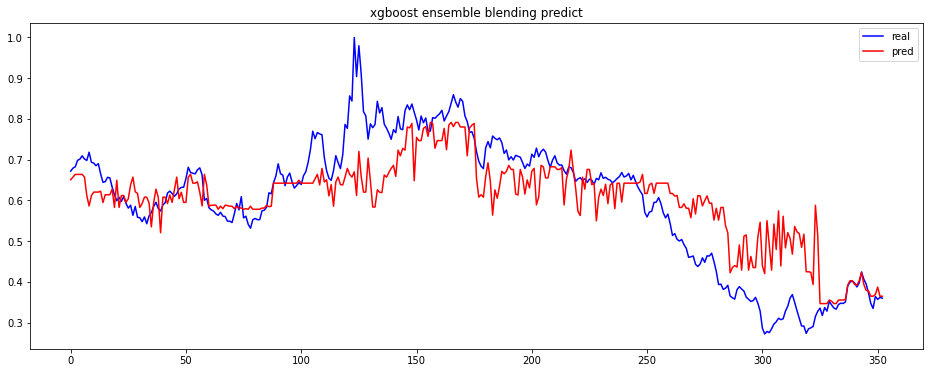

In [125]:
fig = plt.figure( figsize = (16,6))
chart  = fig.add_subplot(1,1,1)
chart.plot(test_y, color = 'blue',label = 'real')
chart.plot(final, color = 'red',label = 'pred')
chart.set_title('xgboost ensemble blending predict')
plt.legend(loc='best')

In [127]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test_y, final))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.092
